## Import Necessary Libraries

In [1]:
## Import necessary libraries
import pandas as pd
import numpy as np
import random 
from urllib.parse import quote
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

## Import libraries for the model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm.notebook import trange
from sklearn.metrics import mean_squared_error, r2_score

## Set path for saving model training results
import os
os.makedirs('./result', exist_ok=True)

## Set Cuda for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## Set random seed
def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

# Set seed
seed_val = 77
set_seed(seed_val)

cuda


## Selecting Data Columns
* Tag names are loaded in sequential order.
* The process of selecting the required tag names from the tag name list.

In [2]:
# Function to display tag names
def show_column(URL):
    
    # Load tag name data
    df = pd.read_csv(URL)
    
    # Convert to list format
    df = df.values.reshape(-1)
    
    return df.tolist()

In [3]:
## Set parameters for displaying tag names
table = 'gold'

NAME_URL = f'http://127.0.0.1:5654/db/tql/datahub/api/v1/get-tag-names.tql?table={table}'

## Generate tag name list
name = show_column(NAME_URL)

In [4]:
name

['close', 'high', 'low', 'open', 'rsi14', 'sma14']

## Converting TAG Name Format
* After checking all the Tag Names from the Gold Price dataset in the previous step, extract only the columns to be used and convert them into parameter format.
* Use tag names Close, rsi14, sma14.

In [5]:
# Set the desired tag names
tags = ['close', 'rsi14', 'sma14']

# Wrap each item in the list with single quotes and separate with commas
tags_ = ",".join(f"'{tag}'" for tag in tags)

# Check the selected tag names
print(tags_)

'close','rsi14','sma14'


## Load Gold Price Dataset
* Load the data using tag names

In [6]:
# Data loading parameter settings

# Set the tag table name
table = 'gold'
# Set the tag names
name = quote(tags_, safe=":/")
# Set the time format 
timeformat = 'default'
# Set the data start time
start_time = quote('2010-01-03 18:00:00')
# Set the data end time
end_time = quote('2023-12-29 16:55:00')

In [7]:
# Data loading function
def data_load(table, name, start_time, end_time, timeformat):
    
    # Load data 
    df = pd.read_csv(f'http://127.0.0.1:5654/db/tql/datahub/api/v1/select-rawdata.tql?table={table}&name={name}&start={start_time}&end={end_time}&timeformat={timeformat}')

    # Convert to data grouped by the time
    df = df.pivot_table(index='TIME', columns='NAME', values='VALUE', aggfunc='first').reset_index()

    # Set TIME column
    df['TIME'] = pd.to_datetime(df['TIME'])
    
    # Set time index
    df.set_index('TIME', inplace=True)
    
    # Move 'value' column to the end
    df['close'] = df.pop('close')
        
    return df

In [8]:
# Load data
df = data_load(table, name, start_time, end_time, timeformat)
df

NAME,rsi14,sma14,close
TIME,,,
2010-01-03 18:00:00,81.98,1096.38,1099.95
2010-01-03 18:05:00,79.17,1096.72,1099.75
2010-01-03 18:10:00,75.02,1097.03,1099.45
2010-01-03 18:15:00,75.02,1097.30,1099.45
2010-01-03 18:20:00,67.50,1097.50,1098.90
...,...,...,...
2023-12-29 16:35:00,39.44,2063.48,2062.96
2023-12-29 16:40:00,37.12,2063.27,2062.61
2023-12-29 16:45:00,36.79,2063.06,2062.56


In [9]:
# Train data: from 2010 to 2022.12.31
# Test data: 2023

train = df[df.index < '2023-01-01']
test = df[(df.index.year == 2023)]

## Data Preprocessing
* 1 Min-Max Scaling

### 1. Applying Min-Max Scaling
* Apply to both input data and target data separately to facilitate conversion back to original values after testing. 

In [10]:
# Set up scalers
scaler_data = MinMaxScaler()
scaler_target = MinMaxScaler()

# Apply scalers
train_ = scaler_data.fit_transform(train.iloc[:, :-1].values)
train_t = scaler_target.fit_transform(train.iloc[:, -1:].values)

test_ = scaler_data.transform(test.iloc[:, :-1].values)
test_t = scaler_target.transform(test.iloc[:, -1:].values)

# Set each DataFrames
train_scaled = pd.DataFrame(train_)  
train_scaled['close'] = train_t

test_scaled = pd.DataFrame(test_)
test_scaled['close'] = test_t

## Dataset & Loader Setup

In [11]:
class Gold_Dataset(Dataset):

    def __init__(self, df):
        self.freq_data = df.iloc[:,:-1]
        self.label = df.iloc[:,-1:].squeeze()

    def __len__(self):
        return len(self.freq_data)

    def __getitem__(self, index):

        input_time_data = self.freq_data.iloc[index,:]
        input_time_data = torch.Tensor(input_time_data).expand(1, input_time_data.shape[0])
        label = self.label[index]

        return input_time_data, label

In [12]:
# Set up datasets  
train_ = Gold_Dataset(train_scaled)
test_ = Gold_Dataset(test_scaled)

# Set up data loaders
train_dataloader = DataLoader(train_, batch_size=1024, shuffle=False)
test_dataloader = DataLoader(test_, batch_size=1024, shuffle=False)

In [13]:
# Verify DataLoader application and check the shape of the input data
print(list(train_dataloader)[0][0].shape)

torch.Size([1024, 1, 2])


## Model Configuration
* Using Temporal Convolutional Network(TCN) model.

In [14]:
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, dropout=0.2):
        super(TemporalBlock, self).__init__()
        padding = (kernel_size - 1) * dilation  # Set padding based on kernel size and dilation
        # First 1D convolution layer
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        
        # Second 1D convolution layer
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        
        # Construct the sequence of layers
        self.net = nn.Sequential(self.conv1, self.relu1, self.dropout1, self.conv2, self.relu2, self.dropout2)
        
        # Downsample for residual connection if needed
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        # Trim the output to match the input size (fixing size mismatch due to padding)
        out = out[:, :, :x.size(2)]
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TCN, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size, 
                                     dropout=dropout)]
        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], 1)  # Output layer for regression tasks

    def forward(self, x):
        x = self.network(x)
        x = x[:, :, -1]  # Use the output from the last time step
        return self.linear(x)

In [15]:
# Model configuration parameters
input_channels = 1
hidden_channels = [25, 50, 100] 
kernel_size = 3
dropout = 0.2

# Learning rate
learning_rate = 0.001

# Initialize the model, loss, and optimizer
model = TCN(num_inputs=input_channels, num_channels=hidden_channels, kernel_size=kernel_size, dropout=dropout).to(device)

# Configure loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Check the model architecture
print(model)

TCN(
  (network): Sequential(
    (0): TemporalBlock(
      (conv1): Conv1d(1, 25, kernel_size=(3,), stride=(1,), padding=(2,))
      (relu1): ReLU()
      (dropout1): Dropout(p=0.2, inplace=False)
      (conv2): Conv1d(25, 25, kernel_size=(3,), stride=(1,), padding=(2,))
      (relu2): ReLU()
      (dropout2): Dropout(p=0.2, inplace=False)
      (net): Sequential(
        (0): Conv1d(1, 25, kernel_size=(3,), stride=(1,), padding=(2,))
        (1): ReLU()
        (2): Dropout(p=0.2, inplace=False)
        (3): Conv1d(25, 25, kernel_size=(3,), stride=(1,), padding=(2,))
        (4): ReLU()
        (5): Dropout(p=0.2, inplace=False)
      )
      (downsample): Conv1d(1, 25, kernel_size=(1,), stride=(1,))
      (relu): ReLU()
    )
    (1): TemporalBlock(
      (conv1): Conv1d(25, 50, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
      (relu1): ReLU()
      (dropout1): Dropout(p=0.2, inplace=False)
      (conv2): Conv1d(50, 50, kernel_size=(3,), stride=(1,), padding=(4,), di

## Model Training

* Save the model with the Best Loss.

In [16]:
# Initialize loss
train_loss = []
# Initialize total step
total_step = len(train_dataloader)
# Set number of epochs
epoch_in = trange(100, desc='training')
# Initialize best Loss value
best_Loss= np.inf

# Start model training
for epoch in epoch_in:
    model.to(device)
    model.train()
    running_loss = 0.0

    for batch_idx, train_data in enumerate(train_dataloader):

        inputs = train_data[0].to(device).float()
        target = train_data[1].to(device).float()

        optimizer.zero_grad()
        
        # Input to the model
        outputs = model(inputs)
    
        # Calculate loss
        loss = criterion(outputs.squeeze(), target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss)}')  

    # Save the best model
    if best_Loss > np.mean(train_loss):
        best_Loss = np.mean(train_loss)
        torch.save(model, f'./result/Gold_Price_General.pt')
        print('Model saved')
    epoch_in.set_postfix_str(f"epoch = {epoch}, best_Loss = {best_Loss}")

training:   0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\MACH-DE-28\anaconda3\envs\test\lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,



train loss: 0.002201466318107981
Model saved

train loss: 0.0026898771652058722

train loss: 0.002196694558545128
Model saved

train loss: 0.0017008731821825532
Model saved

train loss: 0.0013798674931236204
Model saved

train loss: 0.0011638636058371964
Model saved

train loss: 0.0010061356674325847
Model saved

train loss: 0.0008890439129649953
Model saved

train loss: 0.0008035001063926706
Model saved

train loss: 0.0007321085625758011
Model saved

train loss: 0.0006728761906020782
Model saved

train loss: 0.0006240391354466481
Model saved

train loss: 0.0005830505118532492
Model saved

train loss: 0.0005472796798676696
Model saved

train loss: 0.0005151901416170029
Model saved

train loss: 0.000486535449266724
Model saved

train loss: 0.00046143389489760656
Model saved

train loss: 0.0004388872110191028
Model saved

train loss: 0.0004187117175769809
Model saved

train loss: 0.0004004268906826869
Model saved

train loss: 0.00038384265646187516
Model saved

train loss: 0.00036874794

## Model Testing

In [17]:
# Load the best model
model_ = torch.load(f'./result/Gold_Price_General.pt')

In [19]:
# Initial settings 
output_test = []
target_test = []

with torch.no_grad():
    model_.eval()
    running_loss_t = 0.0
    
    for batch_idx, test_data in enumerate(test_dataloader):
        
        inputs_t = test_data[0].to(device).float()
        target_t = test_data[1].to(device).float()

        outputs_t = model_(inputs_t)
        
        output_test.append(outputs_t)
        target_test.append(target_t)
        
# Combine tensors into one
combined_tensor_target = torch.cat(target_test, dim=0)
combined_tensor_pred = torch.cat(output_test, dim=0)

# Use only the last value of the window
last_values_target = combined_tensor_target[: -1].cpu()
last_values_pred = combined_tensor_pred[: -1].cpu()

# Inverse transform using MinMaxScaler 
real_values = scaler_target.inverse_transform(last_values_target.numpy().reshape(-1, 1))
real_pred_values = scaler_target.inverse_transform(last_values_pred.numpy().reshape(-1, 1))

## Model Performance Evaluation

In [20]:
# Calculate MSE
mse = mean_squared_error(real_values, real_pred_values)
print("Mean Squared Error:", mse)

# Calculate R² Score
r2 = r2_score(real_values, real_pred_values)
print("R² Score:", r2)

Mean Squared Error: 9.20388
R² Score: 0.9974234454942439


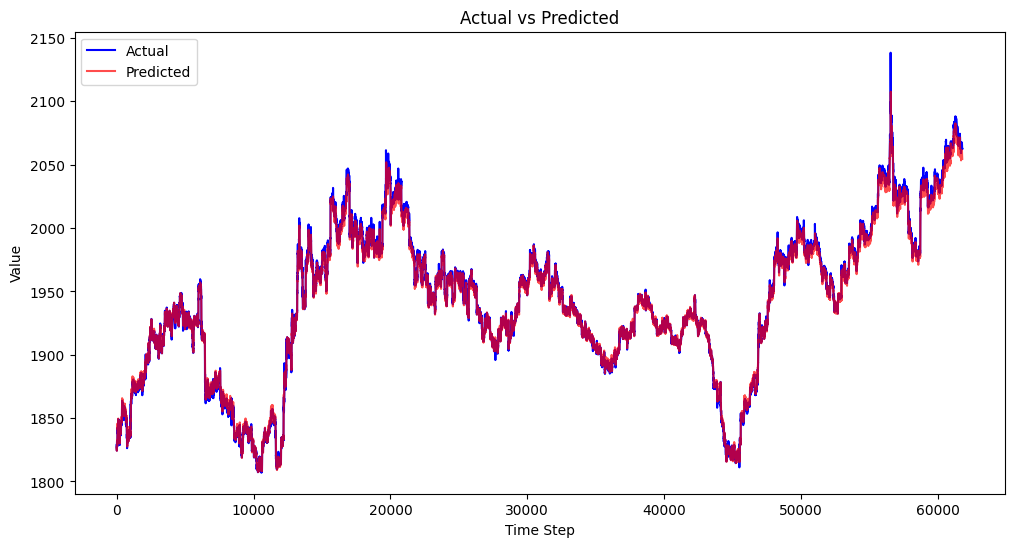

In [21]:
# Compare the test results: Actual values vs Predicted values
plt.figure(figsize=(12, 6))
plt.plot(real_values, label='Actual', color='blue')
plt.plot(real_pred_values, label='Predicted', color='red', alpha=0.7)
plt.title('Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()